In [1]:
import os
import zipfile
import json
import pandas as pd
import math
import rioxarray
import geopandas
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool
import numpy as np

## Gather data from floods

Each flood event in flood database consists of flood levels in a tif file and associated metadata in a json file.

Flood data is downloadable with instructions from https://github.com/cloudtostreet/MODIS_GlobalFloodDatabase or as individual flood files from https://global-flood-database.cloudtostreet.ai/.

In [4]:
flood_db_path = 'flood_db\\gfd_v1_4'

def load_flood_properties(file):
    '''Loads properties and bounding box coordinates for a flood event from flood db'''
    with zipfile.ZipFile(file) as z:
        json_file = [file_name for file_name in z.namelist() if file_name.endswith('.json')]
        with z.open(json_file[0]) as f:
            data = f.read()
            properties = json.loads(data)
            properties['fname'] = file

        tif_file = [file_name for file_name in z.namelist() if file_name.endswith('.tif')]
        # Extract tif files for processing
        # Some flood may contain multiple tifs, read only first
        z.extract(tif_file[0], 'temp')
        with rioxarray.open_rasterio('temp/' + tif_file[0]).squeeze() as data:
            properties['xmin'] = data.coords['x'].min().values
            properties['xmax'] = data.coords['x'].max().values
            properties['ymin'] = data.coords['y'].min().values
            properties['ymax'] = data.coords['y'].max().values
            properties['flood_tiles'] = np.nansum(data.values[0,:,:])

    return(properties)

In [5]:
properties_list = [load_flood_properties(flood_db_path + '\\' + fname) for fname in os.listdir(flood_db_path)]
floods_df = pd.DataFrame(properties_list)
floods_df.to_csv('floods_df.tsv', sep = '\t')

## Estimate probability of capturing a flood

Satellite on a polar orbit has a change of flying over a area that is tied to circumference of earth at the events latitude.

A flood event is considered captured by satellite if floods centroid coordinates were within satellites swath width.

Capture probability is calculated per cycle and probability each cycle is considered independent of each other. This seems appropriate as
- We are considering a short time frame 24h even if given enough orbits satellite would deterministically scan any area.
- Flood widths are small compared to distances between scans of consecutive orbits.

In [8]:
R = 6371
cycle_days = 12
orbits_per_cycle = 175
n_satellites = 1

def radius_at_lat(lat):
    return math.sin(math.pi/2 - math.radians(lat)) * R

def circumference_at_lat(lat):
    r = radius_at_lat(lat)
    return 2*math.pi*r

def prob_per_orbit(lat, swath_width):
    circ = circumference_at_lat(lat)
    if (circ == 0):
        return(1)
    if (swath_width > circumference_at_lat(lat)):
        return(1)

    return (swath_width) / circumference_at_lat(lat)

def prob_per_timeframe(lat, swath_width, time=24):
    p = prob_per_orbit(lat, swath_width)
    # Satellite passes any longitude line twice in one orbit
    passes_per_orbit = 2
    orbits = orbits_per_cycle / cycle_days * time / 24 * passes_per_orbit * n_satellites
    return(1-pow(1-p, orbits))

In [10]:
swath_width = 400
floods_df['capture_p_in_24h'] = floods_df.apply(lambda x: prob_per_timeframe(x['dfo_centroid_y'], swath_width), axis=1)
floods_df.to_csv('floods_df.tsv', sep = '\t')

## Features

Calculate flood sizes from bounding box and derive new variables from existing properties.

In [11]:
# Some issue using projection where distances are better calculated.
# Lat lon distances could still be useful for our model
ll = geopandas.points_from_xy(x=floods_df['xmin'], y=floods_df['ymin'], crs=4326)#.to_crs(1029)
ul = geopandas.points_from_xy(x=floods_df['xmin'], y=floods_df['ymax'], crs=4326)#.to_crs(1029)
ur = geopandas.points_from_xy(x=floods_df['xmax'], y=floods_df['ymax'], crs=4326)#.to_crs(1029)

floods_df['flood_width'] = ul.distance(ur)
floods_df['flood_height'] = ll.distance(ul)
floods_df['flood_area'] = floods_df['flood_width'] * floods_df['flood_height']

c:\Users\ville.koponen\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py:3308: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
c:\Users\ville.koponen\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py:3308: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [12]:
pd.set_option('display.max_rows', None)
floods_df['dfo_main_cause'].value_counts()

dfo_main_cause
Heavy rain                             321
Heavy Rain                             189
Monsoonal rain                          81
Torrential Rain                         73
Monsoonal Rain                          55
Tropical cyclone                        32
Snowmelt                                25
Rain and snowmelt                       11
Tropical Cyclone                        10
Brief torrential rain                    8
Heavy Rain and Snowmelt                  6
Dam/Levy, break or release               6
Monsoon Rains                            4
Heavy monsoon rains                      3
Ice jam/break-up                         3
Snow Melt                                3
Monsoon Rain                             2
Heavy seasonal rains                     2
Tropical Storm Fung-Wong                 2
Tropical Storm                           2
Tropical Storm Trudy                     1
Monoonal Rain                            1
Monsoonal Ran                          

In [18]:
floods_df['length_days'] = ((pd.to_datetime(floods_df['ended'],format='%Y-%m-%d'))-(pd.to_datetime(floods_df['began'],format='%Y-%m-%d'))).dt.days
floods_df['n_countries_affected'] = floods_df.apply(lambda x: len(x['gfd_country_name'].split(',')), axis=1)
floods_df['n_causes'] = floods_df.apply(lambda x: len(x['dfo_main_cause'].split(',')), axis=1)

def deduct_main_cause(causes):
    '''Collate typical flood causes and spellings '''
    if 'dam' in causes.lower():
        return 'dam'
    if ('storm' in causes.lower() or
        'stom' in causes.lower() or
        'strom' in causes.lower() or
        'hurricane' in causes.lower() or
        'typhoon' in causes.lower() or
        'cyclone' in causes.lower()):
        return 'storm'
    if ('rain' in causes.lower() or
        'ran' in causes.lower()):
        return 'rain'
    if 'snow' in causes.lower() or 'ice' in causes.lower():
        return 'snow'
    return 'other'

floods_df['main_cause'] = floods_df.apply(lambda x: deduct_main_cause(x['dfo_main_cause']), axis=1)
floods_df.to_csv('floods_df.tsv', sep = '\t')


In [15]:
floods_df.to_csv('floods_df.tsv', sep = '\t')

In [14]:
floods_df.loc[floods_df['main_cause'] == 'other']['dfo_main_cause'].value_counts()

dfo_main_cause
Tsunami    1
Name: count, dtype: int64

In [53]:
columns=['capture_p_in_24h', 'dfo_centroid_y', 'dfo_centroid_x', 'flood_width', 'flood_height', 'flood_area', 'flood_tiles', 'length_days', 'dfo_severity', 'n_countries_affected', 'dfo_displaced', 'dfo_dead']

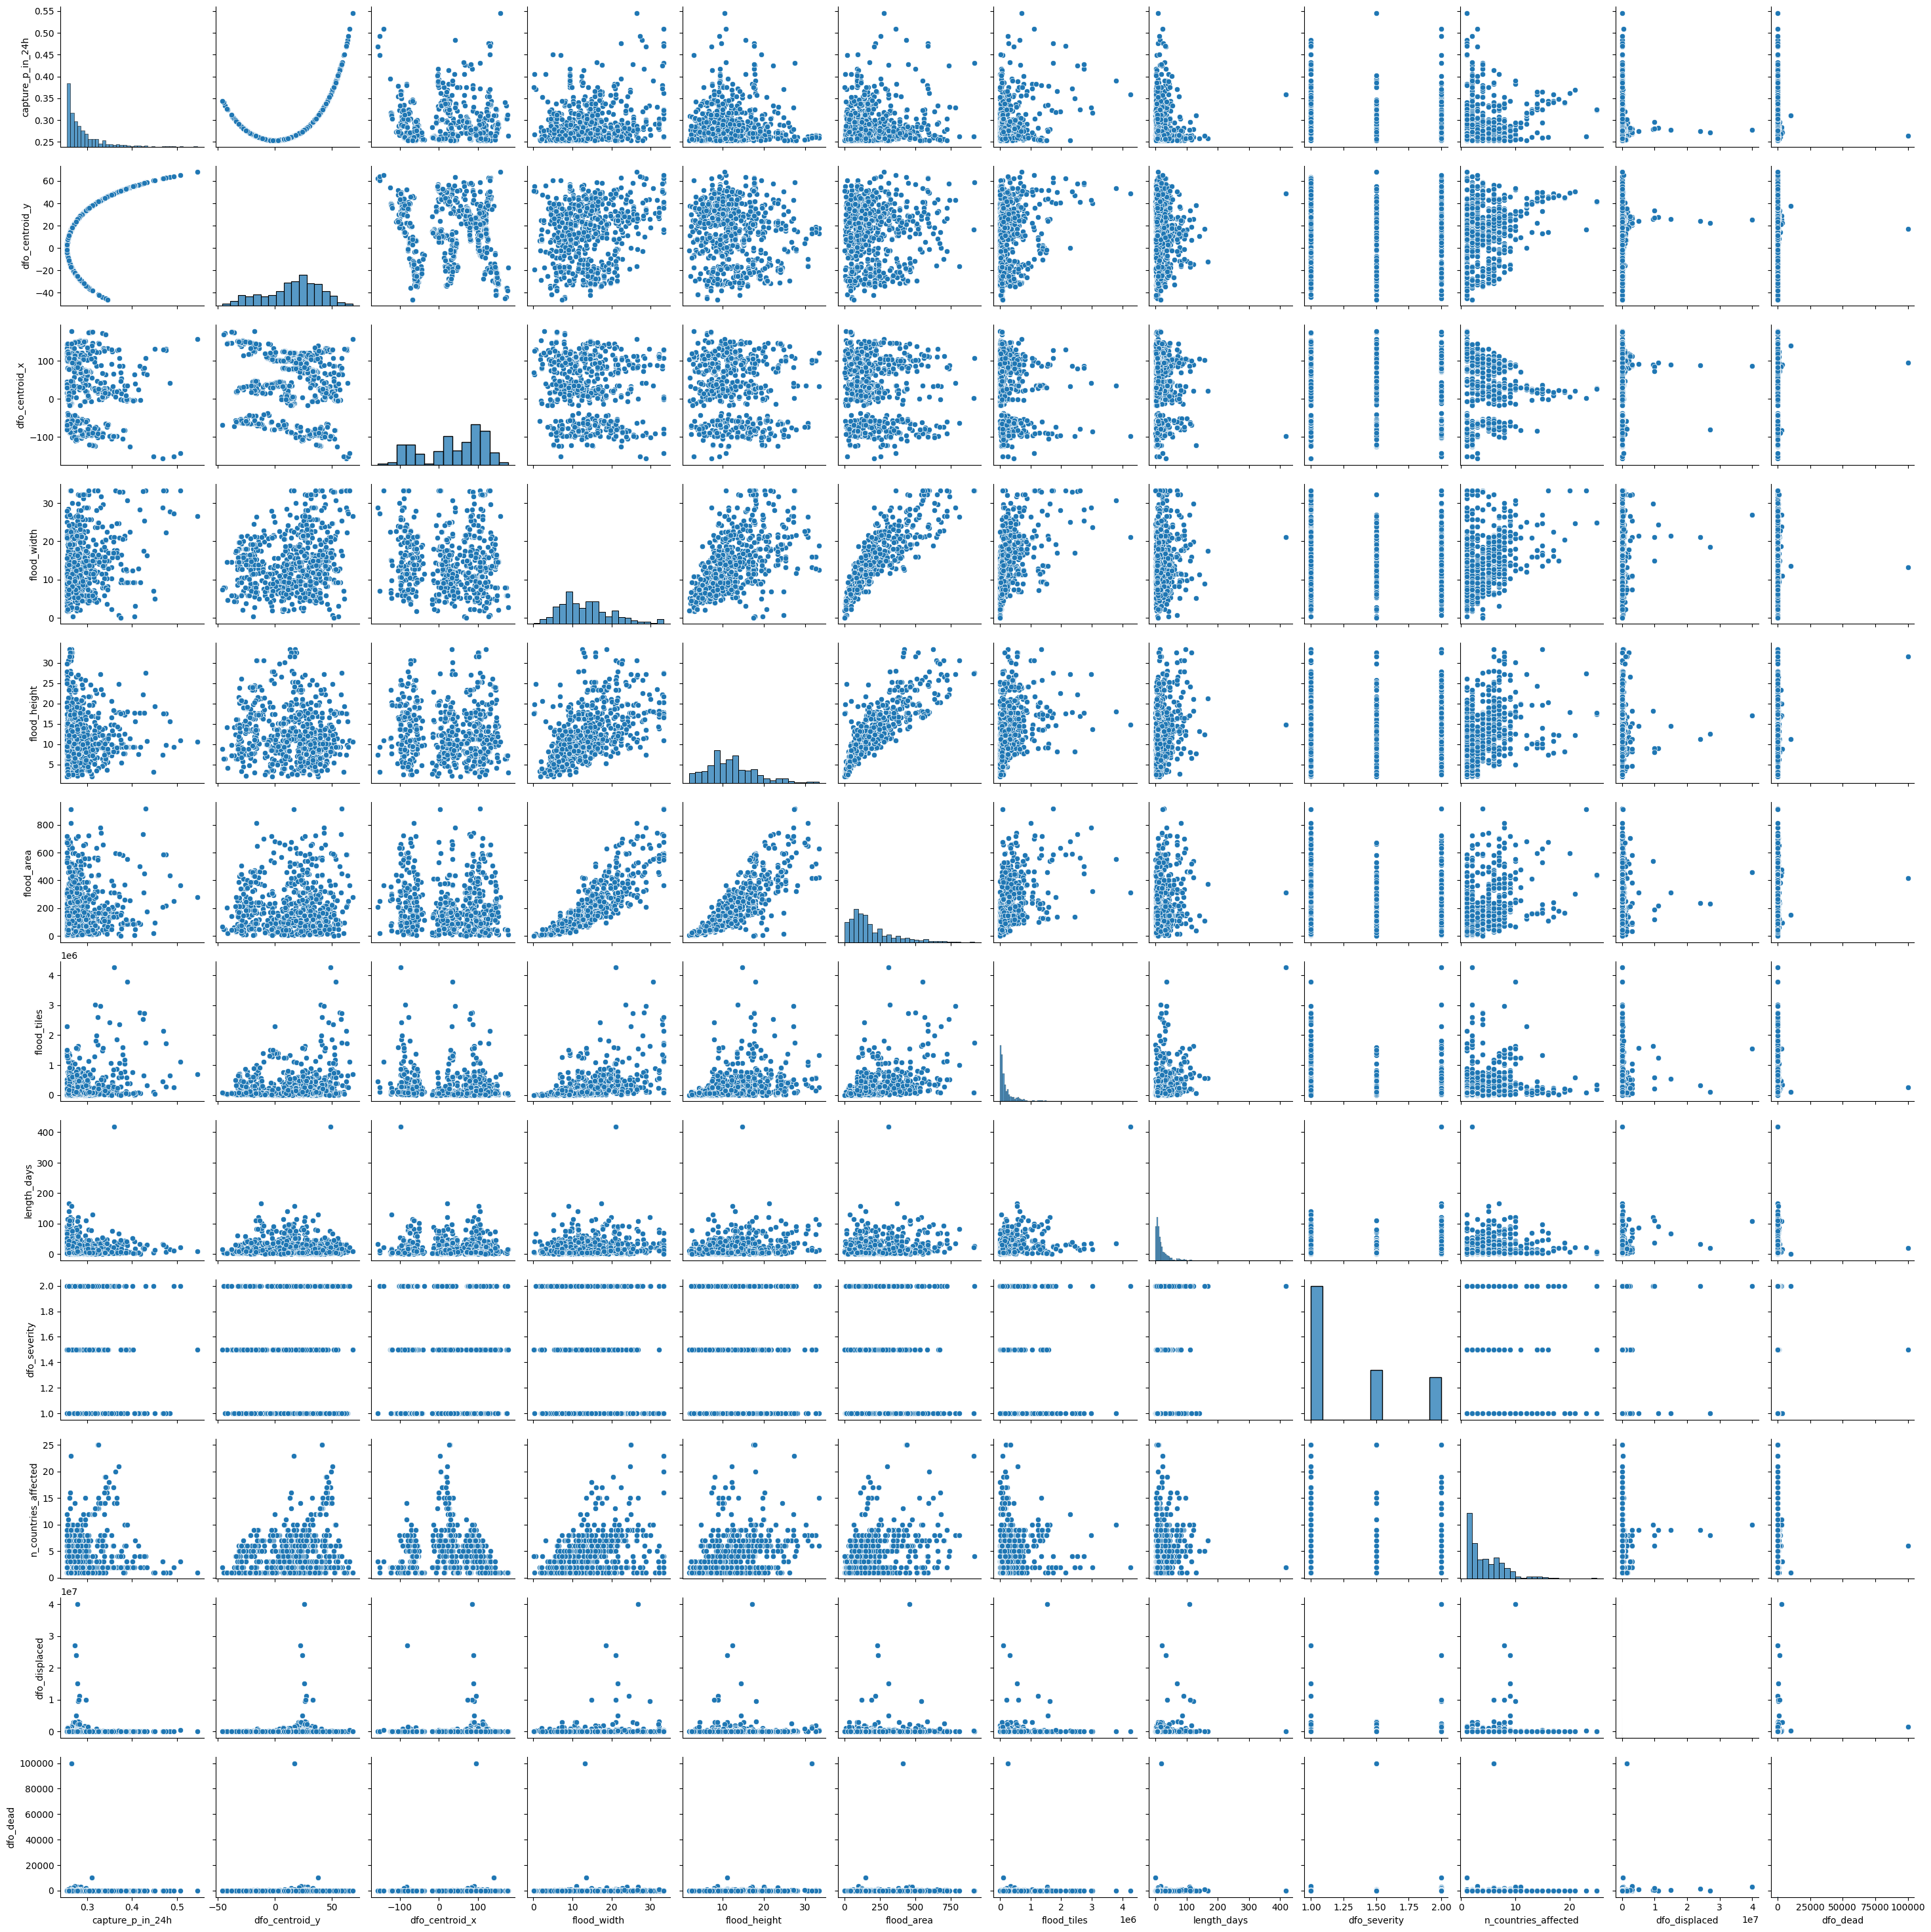

In [54]:
sns.pairplot(floods_df.filter(columns));

<Axes: >

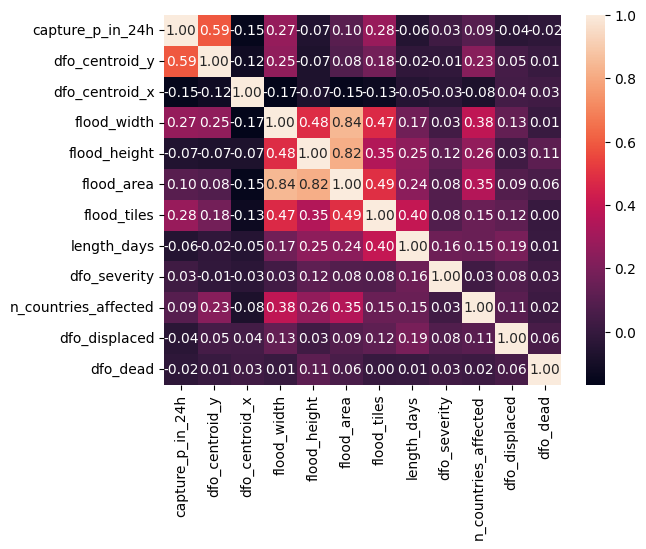

In [55]:
sns.heatmap(floods_df.filter(columns).corr(), annot = True, fmt = '.2f')

<Axes: xlabel='capture_p_in_24h', ylabel='main_cause'>

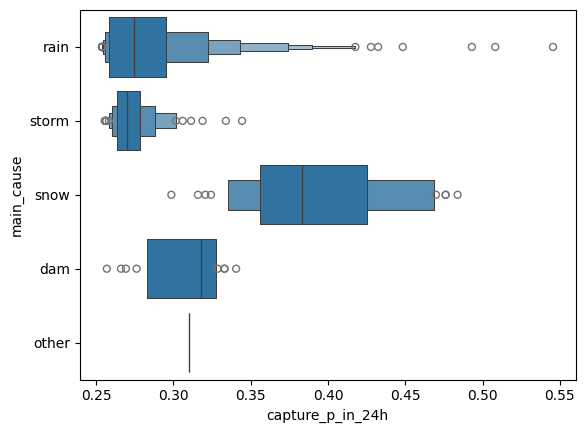

In [22]:
sns.boxenplot(data=floods_df, x="capture_p_in_24h", y="main_cause")

In [23]:
floods_df["dfo_country"].unique()
big_countries = floods_df.loc[floods_df["dfo_country"].isin(['Australia', 'China', 'Russia', 'USA', 'Germany', 'France', 'Brazil', 'Japan', 'United Kingdom'])]

<Axes: xlabel='capture_p_in_24h', ylabel='dfo_country'>

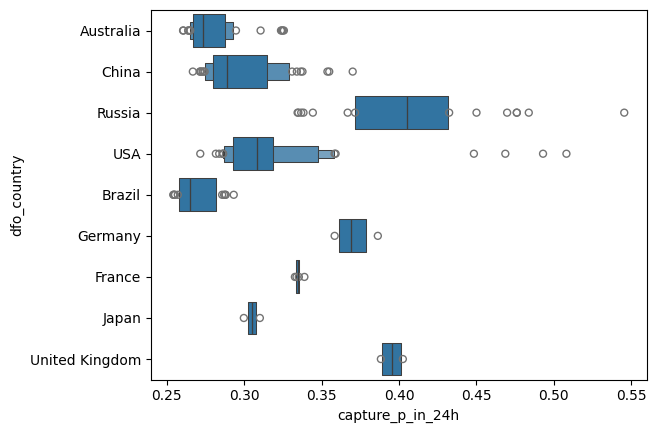

In [24]:
sns.boxenplot(data=big_countries, x="capture_p_in_24h", y="dfo_country")

Observations from plots:
- Capture probability was generated from latitude coordinate and exhibits a clear non-linear relationship with it.
- Rest of the features have small correlations with capture probability.
- Size related features are strongly correlated.
- Latitude affects capture probability
    - Floods caused by snow are more common in high latitudes and floods caused by (tropical) storms are more common in lower.
    - Floods are more likely to be caught in countries in lower latitudes.

## Model

Tree based models often offer good accuracy in wide variety of prediction tasks without needing a long time to tune model parameters correctly.

Some of our columns are categorical. Some ways to deal with categories are not applicable here:
- Can't convert to integers as there is no reasonable way rank categories between each other in this context.
- One-hot encoding leads to a sparse table which can be difficult for tree models.

Tree-based models can work poorly when asked to extrapolate data ranges not seen in training data. Global flood database in luckily very comprehensive.

With these considerations, we'll fit a gradient boosting based model with the [catboost](https://catboost.ai/) library.

In [2]:
floods_df = pd.read_csv('floods_df.tsv', sep='\t')

In [25]:
def make_model_data(data, columns, cat_columns = ['dfo_country', 'main_cause']):
    '''Create data for training a catboost model'''
    y = data.pop('capture_p_in_24h')
    X = data.filter(columns + cat_columns)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

    train_pool = Pool(X_train,
                      y_train,
                      cat_features=cat_columns)
    test_pool = Pool(X_test,
                     y_test,
                     cat_features=cat_columns)

    return(train_pool, test_pool, X_test.columns)

def show_model_performance(model, train_pool, test_pool, columns):
    '''Prints values to evaluate model performance'''

    train_metrics = model.eval_metrics(train_pool, metrics=['RMSE', 'R2'])
    test_metrics = model.eval_metrics(test_pool, metrics=['RMSE', 'R2'])

    print(f'R2 train: {train_metrics['R2'][-1]:.4f}')
    print(f'R2 test:  {test_metrics['R2'][-1]:.4f}')
    print(f'RMSE train: {train_metrics['RMSE'][-1]:.4f}')
    print(f'RMSE test:  {test_metrics['RMSE'][-1]:.4f}')

    df = pd.DataFrame({
        'feature': columns,
        'importance': model.get_feature_importance()
    })

    print(df)


In [ ]:
columns=['capture_p_in_24h', 'dfo_centroid_y', 'dfo_centroid_x', 'flood_tiles', 'length_days', 'dfo_severity', 'n_countries_affected', 'dfo_displaced', 'dfo_dead']

In [26]:
train_pool, test_pool, model_columns = make_model_data(floods_df.copy(), columns)

model = CatBoostRegressor(loss_function='RMSE')
model.fit(train_pool)

Learning rate set to 0.037877
0:	learn: 0.0405023	total: 152ms	remaining: 2m 31s
1:	learn: 0.0394404	total: 166ms	remaining: 1m 22s
2:	learn: 0.0385129	total: 180ms	remaining: 59.9s
3:	learn: 0.0374001	total: 196ms	remaining: 48.9s
4:	learn: 0.0363978	total: 205ms	remaining: 40.8s
5:	learn: 0.0355004	total: 219ms	remaining: 36.2s
6:	learn: 0.0345873	total: 234ms	remaining: 33.1s
7:	learn: 0.0338005	total: 247ms	remaining: 30.6s
8:	learn: 0.0329547	total: 260ms	remaining: 28.7s
9:	learn: 0.0322250	total: 274ms	remaining: 27.1s
10:	learn: 0.0314070	total: 286ms	remaining: 25.7s
11:	learn: 0.0306404	total: 298ms	remaining: 24.5s
12:	learn: 0.0299240	total: 311ms	remaining: 23.6s
13:	learn: 0.0292687	total: 325ms	remaining: 22.9s
14:	learn: 0.0286486	total: 338ms	remaining: 22.2s
15:	learn: 0.0280020	total: 350ms	remaining: 21.5s
16:	learn: 0.0273320	total: 362ms	remaining: 20.9s
17:	learn: 0.0266883	total: 375ms	remaining: 20.5s
18:	learn: 0.0259528	total: 389ms	remaining: 20.1s
19:	learn

In [27]:
show_model_performance(model, train_pool, test_pool, model_columns)

R2 train: 0.9996
R2 test:  0.9974
RMSE train: 0.0008
RMSE test:  0.0019
                feature  importance
0        dfo_centroid_y   92.195494
1        dfo_centroid_x    1.496594
2           flood_tiles    1.235160
3           length_days    0.508344
4          dfo_severity    0.461252
5  n_countries_affected    1.056301
6         dfo_displaced    1.403060
7              dfo_dead    0.349064
8           dfo_country    0.012455
9            main_cause    1.282276


Model has great fit. This is to be expected when latitude is included in the model. Importance scores show that other features hardly matter.

In [31]:
columns_no_latlon = ['capture_p_in_24h', 'flood_tiles', 'length_days', 'dfo_severity', 'n_countries_affected', 'dfo_displaced', 'dfo_dead']

In [42]:
train_pool, test_pool, model_columns = make_model_data(floods_df.copy(), columns_no_latlon)

model_no_lat = CatBoostRegressor(loss_function='RMSE', early_stopping_rounds=10)
model_no_lat.fit(train_pool)

Learning rate set to 0.037877
0:	learn: 0.0410261	total: 18ms	remaining: 17.9s
1:	learn: 0.0404819	total: 31.1ms	remaining: 15.5s
2:	learn: 0.0398650	total: 43.9ms	remaining: 14.6s
3:	learn: 0.0392485	total: 56.9ms	remaining: 14.2s
4:	learn: 0.0387453	total: 72.6ms	remaining: 14.4s
5:	learn: 0.0382523	total: 85.6ms	remaining: 14.2s
6:	learn: 0.0377533	total: 98.2ms	remaining: 13.9s
7:	learn: 0.0372565	total: 111ms	remaining: 13.8s
8:	learn: 0.0367413	total: 124ms	remaining: 13.7s
9:	learn: 0.0363195	total: 138ms	remaining: 13.6s
10:	learn: 0.0359471	total: 151ms	remaining: 13.5s
11:	learn: 0.0355705	total: 160ms	remaining: 13.2s
12:	learn: 0.0352099	total: 174ms	remaining: 13.2s
13:	learn: 0.0348631	total: 187ms	remaining: 13.2s
14:	learn: 0.0344974	total: 203ms	remaining: 13.4s
15:	learn: 0.0341585	total: 219ms	remaining: 13.4s
16:	learn: 0.0338001	total: 232ms	remaining: 13.4s
17:	learn: 0.0334877	total: 247ms	remaining: 13.5s
18:	learn: 0.0331351	total: 260ms	remaining: 13.4s
19:	le

In [40]:
show_model_performance(model_no_lat, train_pool, test_pool, model_columns)

R2 train: 0.7556
R2 test:  0.6806
RMSE train: 0.0205
RMSE test:  0.0208
                feature  importance
0           flood_tiles    8.776132
1           length_days    2.448994
2          dfo_severity    4.471645
3  n_countries_affected    8.531305
4         dfo_displaced    8.449932
5              dfo_dead    4.710862
6           dfo_country   39.807596
7            main_cause   22.803535


Without latitude and longitude features model does a worse job generalizing to test data. RMSE is still fairly low.

Test error starting to increase af decreasing indicates some overfitting.



In [43]:
model_no_lat.eval_metrics(test_pool, metrics=['RMSE', 'R2'], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [34]:
model_no_lat.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType

In [45]:
model_tuned = CatBoostRegressor(loss_function='RMSE', early_stopping_rounds=10)
param_grid = {
    'iterations': [100, 500, 2000],
    'depth': [4, 6, 8],
    'learning_rate': [0.03, 0.1]
}
grid_search_results = model_tuned.grid_search(param_grid, train_pool, cv=3, partition_random_seed=42)
best_params = grid_search_results['params']

print("Best Hyperparameters:")
print(best_params)

show_model_performance(model_tuned, train_pool, test_pool, model_columns)

0:	learn: 0.2825000	test: 0.2824126	best: 0.2824126 (0)	total: 19.1ms	remaining: 1.9s
1:	learn: 0.2744202	test: 0.2744036	best: 0.2744036 (1)	total: 30ms	remaining: 1.47s
2:	learn: 0.2666941	test: 0.2666723	best: 0.2666723 (2)	total: 41.4ms	remaining: 1.34s
3:	learn: 0.2590988	test: 0.2592294	best: 0.2592294 (3)	total: 52.5ms	remaining: 1.26s
4:	learn: 0.2520140	test: 0.2521442	best: 0.2521442 (4)	total: 61.4ms	remaining: 1.17s
5:	learn: 0.2448678	test: 0.2450272	best: 0.2450272 (5)	total: 71.3ms	remaining: 1.12s
6:	learn: 0.2381893	test: 0.2382232	best: 0.2382232 (6)	total: 82.8ms	remaining: 1.1s
7:	learn: 0.2314289	test: 0.2314915	best: 0.2314915 (7)	total: 91.8ms	remaining: 1.06s
8:	learn: 0.2249963	test: 0.2251159	best: 0.2251159 (8)	total: 102ms	remaining: 1.03s
9:	learn: 0.2187849	test: 0.2188847	best: 0.2188847 (9)	total: 114ms	remaining: 1.03s
10:	learn: 0.2126708	test: 0.2127377	best: 0.2127377 (10)	total: 123ms	remaining: 993ms
11:	learn: 0.2066824	test: 0.2068905	best: 0.206

Hyperparameter tuning suggest smaller parameter values.

In [50]:
model_d4 = CatBoostRegressor(
    loss_function='RMSE',
    early_stopping_rounds=10,
    depth=4,
    learning_rate=0.03,
    iterations=500)
model_d4.fit(
    train_pool,
    eval_set=test_pool,
    use_best_model=True)
show_model_performance(model_d4, train_pool, test_pool, model_columns)

0:	learn: 0.0411274	test: 0.0365131	best: 0.0365131 (0)	total: 14.8ms	remaining: 7.4s
1:	learn: 0.0408287	test: 0.0362177	best: 0.0362177 (1)	total: 22.6ms	remaining: 5.62s
2:	learn: 0.0405589	test: 0.0359563	best: 0.0359563 (2)	total: 29.2ms	remaining: 4.84s
3:	learn: 0.0402971	test: 0.0357425	best: 0.0357425 (3)	total: 35.6ms	remaining: 4.42s
4:	learn: 0.0400632	test: 0.0355453	best: 0.0355453 (4)	total: 44.2ms	remaining: 4.38s
5:	learn: 0.0396218	test: 0.0350070	best: 0.0350070 (5)	total: 51.3ms	remaining: 4.22s
6:	learn: 0.0392344	test: 0.0345383	best: 0.0345383 (6)	total: 58.6ms	remaining: 4.12s
7:	learn: 0.0388559	test: 0.0341165	best: 0.0341165 (7)	total: 65.2ms	remaining: 4.01s
8:	learn: 0.0384413	test: 0.0336621	best: 0.0336621 (8)	total: 72.1ms	remaining: 3.93s
9:	learn: 0.0380514	test: 0.0331854	best: 0.0331854 (9)	total: 79.7ms	remaining: 3.9s
10:	learn: 0.0376992	test: 0.0327648	best: 0.0327648 (10)	total: 86.4ms	remaining: 3.84s
11:	learn: 0.0373338	test: 0.0323262	best: 

In [52]:
model_d4.eval_metrics(test_pool, metrics=['RMSE', 'R2'], plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Making the model smaller and using catboosts build in early stopping fixes overfitting.